In [1]:
from __future__ import print_function
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
import seaborn as sns
import itertools
import scipy.stats as ss
import math
from IPython import display
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow.keras import layers


plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
pd.options.display.max_rows = 100

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()


Saving adult_train.csv to adult_train.csv


In [3]:
train = pd.read_csv("adult_train.csv")
train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
train.shape
#train.columns

(32561, 15)

In [5]:
from google.colab import files
uploaded = files.upload()

Saving adult.data to adult.data


In [6]:
data = pd.read_csv("adult.data", header=None)
data.shape

(32561, 15)

In [0]:
#data.shape
data.columns = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num',
       'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']

In [8]:
data.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
data.shape

(32561, 15)

In [11]:
from google.colab import files
uploaded = files.upload()

Saving adult.test to adult.test


In [12]:
test = pd.read_csv("adult.test", skiprows=1, header=None)
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [13]:
test.shape

(16281, 15)

In [0]:
test.columns = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num',
       'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']

In [15]:
test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


<h4>Removing dot from Target values in test dataset</h4>

In [0]:
test['Target'] = test['Target'].str.rstrip('.')

In [17]:
test['Target'].value_counts()

 <=50K    12435
 >50K      3846
Name: Target, dtype: int64

In [18]:
data['source'] = 'train'
test['source'] = 'test'
data.shape, test.shape

((32561, 16), (16281, 16))

In [19]:
#test.head()
#data.head()
combined = pd.concat([data, test], axis=0)
combined.shape

(48842, 16)

In [20]:
#data.shape
combined['Target'].value_counts()

 <=50K    37155
 >50K     11687
Name: Target, dtype: int64

In [0]:
# cross check
#12435 + 24720 = 37155
# 7841 + 3846 = 11687
#data['Target'].value_counts()

In [0]:
#combined['Education'].value_counts(normalize=True)

In [0]:
#combined['Education_Num'].value_counts(normalize=True)

<h4>Drop Education</h4>

In [21]:
combined = combined.drop('Education', axis=1)
combined.shape

(48842, 15)

<h3>Missing Values</h3>

Note:
* No missing values in numerical variables
* There are some "?" in categorical variables
  * what to impute?

In [22]:
combined.isnull().sum()

Age               0
Workclass         0
fnlwgt            0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_week    0
Country           0
Target            0
source            0
dtype: int64

In [0]:
# Features having '?' = Occupation, Workclass and Country
#combined['Occupation'].value_counts()

In [0]:
cols = ['Workclass', 'Country', 'Occupation']
for col in cols:
  combined[col]=combined[col].str.replace('?', 'Unidentified')

In [0]:
# Cross Checks
#combined['Workclass'].value_counts()
#combined['Country'].value_counts()
#combined['Occupation'].value_counts()

<h3>Statistics</h3>

In [26]:
combined.describe()

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [27]:
combined.describe(include=object)

,Workclass,Marital_Status,Occupation,Relationship,Race,Sex,Country,Target,source
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,7,15,6,5,2,42,2,2
top,Private,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K,train
freq,33906,22379,6172,19716,41762,32650,43832,37155,32561


In [28]:
cat_com = combined.select_dtypes(include='object').columns
num_com = combined.select_dtypes(exclude='object').columns
cat_com

Index(['Workclass', 'Marital_Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country', 'Target', 'source'],
      dtype='object')

In [0]:
# Cross-Check distribution of data and test dataset
#data.describe()
#test.describe()

<h3>Distribution Plot of Raw Numerical Features </h3>

In [0]:
def dist_plot(cols):
  for x in num_com:
    plt.figure()
    sns.distplot(combined[x])
    plt.show()



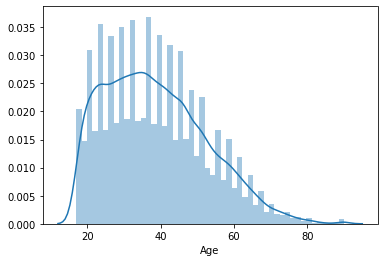

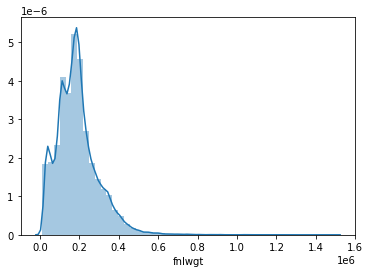

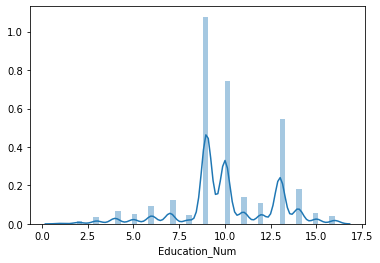

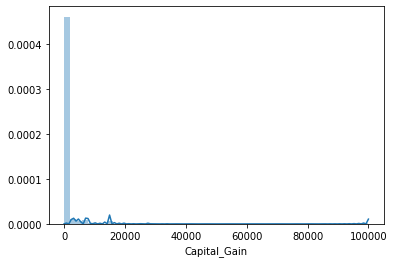

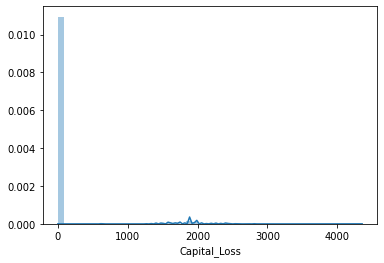

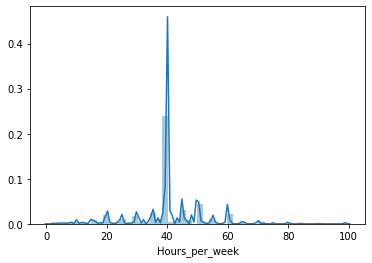

In [30]:
dist_plot(num_com)

<h3>Pair Plot</h3>

Note : Showing distribution of single variables and the relationship between two variables.

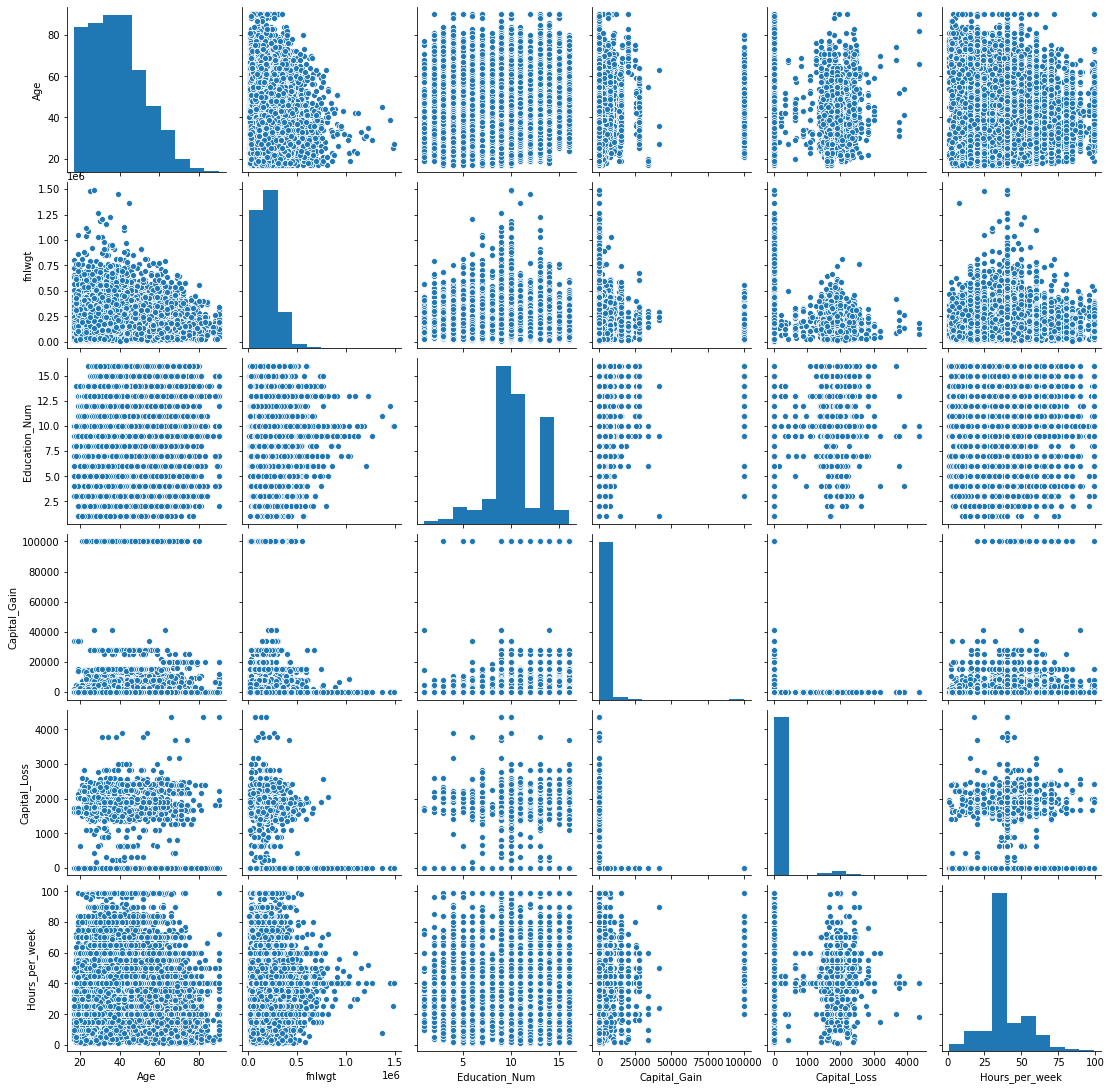

In [31]:
sns.pairplot(combined)

<h3>Numerical Variables Correlation using Pearson's</h3>

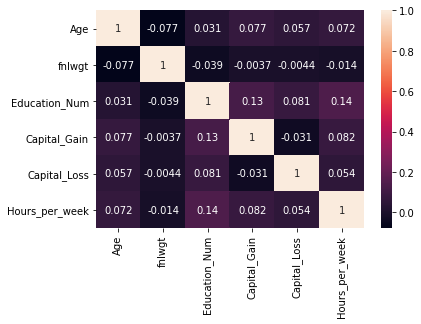

In [32]:
# numerical variables are not correlated
sns.heatmap(combined.corr(), annot=True)

<h3>Categorical Correlation using Cramers V</h3>

Note : 
  * because Target variable is categorical, I haven't check its correlation with numerical variables.
  * Education, Marital Status, Relationship and Occupation have moderate correlation with Target 
  * Sex and Relationship has high correlation ( > 0.5)

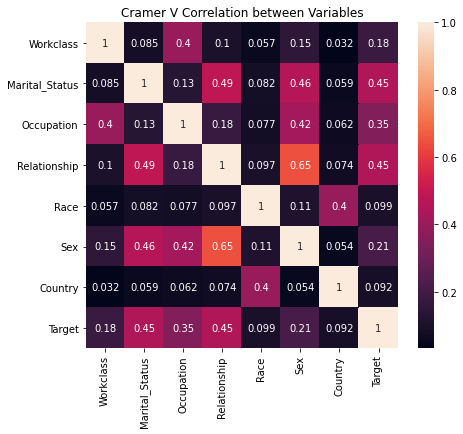

In [33]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = ['Workclass', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
corrM = np.ones((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(combined[col1], combined[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");


<h4>Binary Label</h4>

In [0]:
#combined['Target'].value_counts()

In [0]:
combined['Target'] = np.where(combined["Target"].str.contains("="), 0, 1)

In [0]:
#combined['Target'].value_counts()

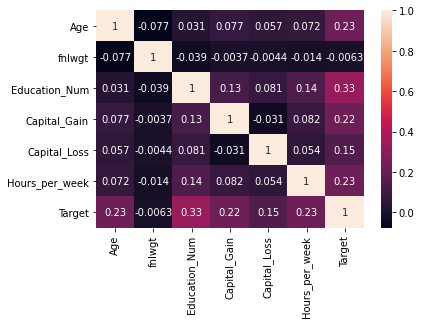

In [37]:
sns.heatmap(combined.corr(), annot=True)

<h3> Split Training - Validation and Test Set</h3>

In [70]:
combined_2 = combined.copy()
combined_2.shape

(48842, 15)

In [71]:
combined_2['source'].value_counts()

train    32561
test     16281
Name: source, dtype: int64

In [72]:
train_df = combined_2[combined_2['source'] == 'train'].copy()
test_df = combined_2[combined_2['source'] == 'test'].copy()

train_df = train_df.drop('source', axis = 1)
test_df = test_df.drop('source', axis = 1)
train_df.shape, test_df.shape

((32561, 14), (16281, 14))

In [73]:
train_df['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

<h4>Normalize Values</h4>

In [74]:
num_cols = train_df.select_dtypes(exclude=np.object).columns
num_cols

Index(['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss',
       'Hours_per_week', 'Target'],
      dtype='object')

In [0]:
for col in['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss','Hours_per_week']:
  train_df[col]= (train_df[col]-train_df[col].mean())/train_df[col].std()

In [0]:
for col in ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss','Hours_per_week']:
  test_df[col]= (test_df[col]-test_df[col].mean())/test_df[col].std()

In [0]:
#train_df.describe()
#test_df.describe()

In [0]:
#train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df, val_df = train_test_split(train_df, test_size=0.2)

<h4>Pandas Dataframe to Tensorflow Dataset</h4>

In [0]:
def df_to_dataset(dataframe, shuffle=True, batch_size=100):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
train_ds = df_to_dataset(train_df)
val_ds = df_to_dataset(val_df)
test_ds = df_to_dataset(test_df)

In [81]:
"""
# Check the format of our data

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature: ', list(feature_batch.keys()))
  print('A batch of ages: ', feature_batch['Age'])
  print('A batch of targets: ', label_batch)

"""

"\n# Check the format of our data\n\nfor feature_batch, label_batch in train_ds.take(1):\n  print('Every feature: ', list(feature_batch.keys()))\n  print('A batch of ages: ', feature_batch['Age'])\n  print('A batch of targets: ', label_batch)\n\n"

<h4>Feature Columns</h4>

One Hot Encoding: 'Race', 'Sex', 'Marital_Status','Relationship'

Embedding Encoding:'Occupation', 'Country', 'Workclass'


In [0]:
cat_cols = train_df.select_dtypes(include=np.object).columns


In [83]:
train_df.head()

,Age,Workclass,fnlwgt,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
9562,-0.482510,Private,1.275298,1.134721,Never-married,Prof-specialty,Own-child,White,Male,-0.145918,-0.216656,-0.035429,United-States,0
15896,-1.435559,Private,0.659153,-0.420053,Never-married,Sales,Not-in-family,White,Male,-0.145918,-0.216656,0.369514,United-States,0
30774,-0.995690,Self-emp-inc,-0.293959,0.357334,Never-married,Transport-moving,Unmarried,White,Male,-0.145918,-0.216656,1.179399,United-States,0
13752,0.543850,Private,-0.075494,-0.420053,Married-civ-spouse,Craft-repair,Husband,Black,Male,0.404365,-0.216656,-0.035429,United-States,0
8984,-1.142313,Private,0.201522,-0.031360,Never-married,Tech-support,Not-in-family,White,Female,0.409375,-0.216656,-0.035429,United-States,0


In [84]:
"""
feature_columns = []

#numeric column
for header in ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss','Hours_per_week',]:
  feature_columns.append(tf.feature_column.numeric_column(header))

# one-hot encoding
Sex = tf.feature_column.categorical_column_with_vocabulary_list(
    'Sex', [' Male', ' Female'])
Sex_one_hot = tf.feature_column.indicator_column(Sex)
feature_columns.append(Sex_one_hot)

Race = tf.feature_column.categorical_column_with_vocabulary_list(
    'Race', [' White', ' Black', ' Other', ' Asian-Pac-Islander',' Amer-Indian-Eskimo'])
Race_one_hot = tf.feature_column.indicator_column(Race)
feature_columns.append(Race_one_hot)

Marital_Status = tf.feature_column.categorical_column_with_vocabulary_list(
    'Marital_Status', [' Married-civ-spouse', ' Separated', ' Never-married', ' Divorced',
       ' Married-spouse-absent', ' Widowed', ' Married-AF-spouse'])
Marital_Status_one_hot = tf.feature_column.indicator_column(Marital_Status)
feature_columns.append(Marital_Status_one_hot)

Relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    'Relationship', [' Husband', ' Not-in-family', ' Unmarried', ' Own-child', ' Wife',
       ' Other-relative'])
Relationship_one_hot = tf.feature_column.indicator_column(Relationship)
feature_columns.append(Relationship_one_hot)

# Embedding Column
Occupation = tf.feature_column.categorical_column_with_vocabulary_list(
    'Occupation', [' Adm-clerical', ' Craft-repair', ' Exec-managerial',
       ' Prof-specialty', ' Unidentified', ' Transport-moving', ' Sales',
       ' Farming-fishing', ' Priv-house-serv', ' Other-service',
       ' Machine-op-inspct', ' Protective-serv', ' Tech-support',
       ' Handlers-cleaners', ' Armed-Forces'])
Occupation_embedding = tf.feature_column.embedding_column(Occupation, dimension=6)
feature_columns.append(Occupation_embedding)

Workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'Workclass', [' Private', ' Local-gov', ' Federal-gov', ' Self-emp-not-inc',
       ' Self-emp-inc', ' Unidentified', ' State-gov', ' Never-worked',
       ' Without-pay'])
Workclass_embedding = tf.feature_column.embedding_column(Workclass, dimension=3)
feature_columns.append(Workclass_embedding)

Country = tf.feature_column.categorical_column_with_vocabulary_list(
    'Country', [' United-States', ' Portugal', ' Columbia', ' El-Salvador',
       ' Ecuador', ' Haiti', ' Jamaica', ' Unidentified', ' Mexico',
       ' China', ' South', ' Philippines', ' Cuba', ' Puerto-Rico',
       ' England', ' Taiwan', ' Poland', ' Canada', ' Hong', ' Ireland',
       ' India', ' Vietnam', ' Outlying-US(Guam-USVI-etc)', ' Germany',
       ' Iran', ' Italy', ' Trinadad&Tobago', ' Japan', ' Peru',
       ' Greece', ' Nicaragua', ' France', ' Dominican-Republic',
       ' Guatemala', ' Honduras', ' Yugoslavia', ' Thailand', ' Hungary',
       ' Cambodia', ' Laos', ' Scotland'])
Country_embedding = tf.feature_column.embedding_column(Country, dimension=8)
feature_columns.append(Country_embedding)
"""

"\nfeature_columns = []\n\n#numeric column\nfor header in ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss','Hours_per_week',]:\n  feature_columns.append(tf.feature_column.numeric_column(header))\n\n# one-hot encoding\nSex = tf.feature_column.categorical_column_with_vocabulary_list(\n    'Sex', [' Male', ' Female'])\nSex_one_hot = tf.feature_column.indicator_column(Sex)\nfeature_columns.append(Sex_one_hot)\n\nRace = tf.feature_column.categorical_column_with_vocabulary_list(\n    'Race', [' White', ' Black', ' Other', ' Asian-Pac-Islander',' Amer-Indian-Eskimo'])\nRace_one_hot = tf.feature_column.indicator_column(Race)\nfeature_columns.append(Race_one_hot)\n\nMarital_Status = tf.feature_column.categorical_column_with_vocabulary_list(\n    'Marital_Status', [' Married-civ-spouse', ' Separated', ' Never-married', ' Divorced',\n       ' Married-spouse-absent', ' Widowed', ' Married-AF-spouse'])\nMarital_Status_one_hot = tf.feature_column.indicator_column(Marital_Status)\nfe

In [0]:
feature_columns_try = []

#numeric column:'Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss','Hours_per_week'
for header in ['Education_Num', 'Age', 'Hours_per_week', 'Capital_Gain', 'Capital_Loss', 'fnlwgt']:
  feature_columns_try.append(tf.feature_column.numeric_column(header))

# one-hot encoding
Sex = tf.feature_column.categorical_column_with_vocabulary_list(
    'Sex', [' Male', ' Female'])
Sex_one_hot = tf.feature_column.indicator_column(Sex)
feature_columns_try.append(Sex_one_hot)

Race = tf.feature_column.categorical_column_with_vocabulary_list(
    'Race', [' White', ' Black', ' Other', ' Asian-Pac-Islander',' Amer-Indian-Eskimo'])
Race_one_hot = tf.feature_column.indicator_column(Race)
feature_columns_try.append(Race_one_hot)

Marital_Status = tf.feature_column.categorical_column_with_vocabulary_list(
    'Marital_Status', [' Married-civ-spouse', ' Separated', ' Never-married', ' Divorced',
       ' Married-spouse-absent', ' Widowed', ' Married-AF-spouse'])
Marital_Status_one_hot = tf.feature_column.indicator_column(Marital_Status)
feature_columns_try.append(Marital_Status_one_hot)

Relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    'Relationship', [' Husband', ' Not-in-family', ' Unmarried', ' Own-child', ' Wife',
       ' Other-relative'])
Relationship_one_hot = tf.feature_column.indicator_column(Relationship)
feature_columns_try.append(Relationship_one_hot)

# Embedding Column
Occupation = tf.feature_column.categorical_column_with_vocabulary_list(
    'Occupation', [' Adm-clerical', ' Craft-repair', ' Exec-managerial',
       ' Prof-specialty', ' Unidentified', ' Transport-moving', ' Sales',
       ' Farming-fishing', ' Priv-house-serv', ' Other-service',
       ' Machine-op-inspct', ' Protective-serv', ' Tech-support',
       ' Handlers-cleaners', ' Armed-Forces'])
Occupation_embedding = tf.feature_column.embedding_column(Occupation, dimension=6)
feature_columns_try.append(Occupation_embedding)

Workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'Workclass', [' Private', ' Local-gov', ' Federal-gov', ' Self-emp-not-inc',
       ' Self-emp-inc', ' Unidentified', ' State-gov', ' Never-worked',
       ' Without-pay'])
Workclass_embedding = tf.feature_column.embedding_column(Workclass, dimension=3)
feature_columns_try.append(Workclass_embedding)

Country = tf.feature_column.categorical_column_with_vocabulary_list(
    'Country', [' United-States', ' Portugal', ' Columbia', ' El-Salvador',
       ' Ecuador', ' Haiti', ' Jamaica', ' Unidentified', ' Mexico',
       ' China', ' South', ' Philippines', ' Cuba', ' Puerto-Rico',
       ' England', ' Taiwan', ' Poland', ' Canada', ' Hong', ' Ireland',
       ' India', ' Vietnam', ' Outlying-US(Guam-USVI-etc)', ' Germany',
       ' Iran', ' Italy', ' Trinadad&Tobago', ' Japan', ' Peru',
       ' Greece', ' Nicaragua', ' France', ' Dominican-Republic',
       ' Guatemala', ' Honduras', ' Yugoslavia', ' Thailand', ' Hungary',
       ' Cambodia', ' Laos', ' Scotland'])
Country_embedding = tf.feature_column.embedding_column(Country, dimension=8)
feature_columns_try.append(Country_embedding)


In [86]:
"""
example_batch = next(iter(train_ds))[0]
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())



Country = tf.feature_column.categorical_column_with_vocabulary_list(
    'Country', [' United-States', ' Portugal', ' Columbia', ' El-Salvador',
       ' Ecuador', ' Haiti', ' Jamaica', ' Unidentified', ' Mexico',
       ' China', ' South', ' Philippines', ' Cuba', ' Puerto-Rico',
       ' England', ' Taiwan', ' Poland', ' Canada', ' Hong', ' Ireland',
       ' India', ' Vietnam', ' Outlying-US(Guam-USVI-etc)', ' Germany',
       ' Iran', ' Italy', ' Trinadad&Tobago', ' Japan', ' Peru',
       ' Greece', ' Nicaragua', ' France', ' Dominican-Republic',
       ' Guatemala', ' Honduras', ' Yugoslavia', ' Thailand', ' Hungary',
       ' Cambodia', ' Laos', ' Scotland'])
Country_embedding = tf.feature_column.embedding_column(Country, dimension=8)


demo(Country_embedding)
"""

"\nexample_batch = next(iter(train_ds))[0]\ndef demo(feature_column):\n  feature_layer = layers.DenseFeatures(feature_column)\n  print(feature_layer(example_batch).numpy())\n\n\n\nCountry = tf.feature_column.categorical_column_with_vocabulary_list(\n    'Country', [' United-States', ' Portugal', ' Columbia', ' El-Salvador',\n       ' Ecuador', ' Haiti', ' Jamaica', ' Unidentified', ' Mexico',\n       ' China', ' South', ' Philippines', ' Cuba', ' Puerto-Rico',\n       ' England', ' Taiwan', ' Poland', ' Canada', ' Hong', ' Ireland',\n       ' India', ' Vietnam', ' Outlying-US(Guam-USVI-etc)', ' Germany',\n       ' Iran', ' Italy', ' Trinadad&Tobago', ' Japan', ' Peru',\n       ' Greece', ' Nicaragua', ' France', ' Dominican-Republic',\n       ' Guatemala', ' Honduras', ' Yugoslavia', ' Thailand', ' Hungary',\n       ' Cambodia', ' Laos', ' Scotland'])\nCountry_embedding = tf.feature_column.embedding_column(Country, dimension=8)\n\n\ndemo(Country_embedding)\n"

In [87]:
feature_columns_try

[NumericColumn(key='Education_Num', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Hours_per_week', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Capital_Gain', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Capital_Loss', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fnlwgt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=(' Male', ' Female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Race', vocabulary_list=(' White', ' Black', ' Other', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo'), dtype=tf.string, default_valu

<h4>Feature Layer</h4>

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns_try)

<h4> Model </h4>

In [89]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [90]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20
261/261 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.8021
Epoch 2/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3574 - accuracy: 0.8346
Epoch 3/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3385 - accuracy: 0.8424
Epoch 4/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3307 - accuracy: 0.8462
Epoch 5/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3268 - accuracy: 0.8487
Epoch 6/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3241 - accuracy: 0.8504
Epoch 7/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8509
Epoch 8/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.8519
Epoch 9/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3211 - accuracy: 0.8525
Epoch 10/20
261/261 [==============================] - 0s 2ms/step - loss: 0.3202 - accuracy: 0.8525

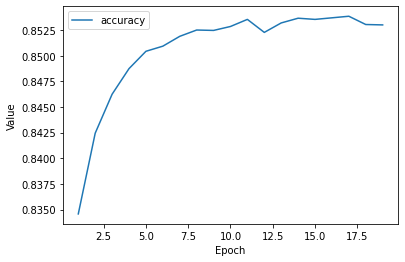

In [91]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "Target"
classification_threshold = 0.5

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

<h4> Test Set</h4>

In [0]:
#test_df.head()

In [93]:
features = {name:np.array(value) for name, value in test_df.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

163/163 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8541


[0.3182472884654999, 0.8541244268417358]

In [0]:
#my_model.get_weights()

<h4>Add Other Metrics</h4>

In [95]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.5
label_name = "Target"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(name='recall',thresholds=classification_threshold,),
      tf.keras.metrics.TruePositives(name='tp',thresholds=classification_threshold),
      tf.keras.metrics.FalsePositives(name='fp',thresholds=classification_threshold),
      tf.keras.metrics.TrueNegatives(name='tn',thresholds=classification_threshold),
      tf.keras.metrics.FalseNegatives(name='fn',thresholds=classification_threshold), 
      tf.keras.metrics.AUC(name='auc')
           
      
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df, epochs, 
                           label_name, batch_size)



Epoch 1/20
261/261 [==============================] - 1s 2ms/step - loss: 0.4522 - accuracy: 0.7930 - precision: 0.6456 - recall: 0.3003 - tp: 1873.0000 - fp: 1028.0000 - tn: 18783.0000 - fn: 4364.0000 - auc: 0.8081
Epoch 2/20
261/261 [==============================] - 1s 2ms/step - loss: 0.3578 - accuracy: 0.8364 - precision: 0.7456 - recall: 0.4808 - tp: 2999.0000 - fp: 1023.0000 - tn: 18788.0000 - fn: 3238.0000 - auc: 0.8885
Epoch 3/20
261/261 [==============================] - 1s 2ms/step - loss: 0.3385 - accuracy: 0.8438 - precision: 0.7377 - recall: 0.5392 - tp: 3363.0000 - fp: 1196.0000 - tn: 18615.0000 - fn: 2874.0000 - auc: 0.8969
Epoch 4/20
261/261 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8472 - precision: 0.7353 - recall: 0.5657 - tp: 3528.0000 - fp: 1270.0000 - tn: 18541.0000 - fn: 2709.0000 - auc: 0.9000
Epoch 5/20
261/261 [==============================] - 1s 2ms/step - loss: 0.3274 - accuracy: 0.8496 - precision: 0.7367 - recall: 0.5786

In [0]:
#hist

In [97]:
hist.columns

Index(['loss', 'accuracy', 'precision', 'recall', 'tp', 'fp', 'tn', 'fn',
       'auc'],
      dtype='object')

In [0]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.figure()
    plt.plot(history.index,  history[metric])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.title(name)
    

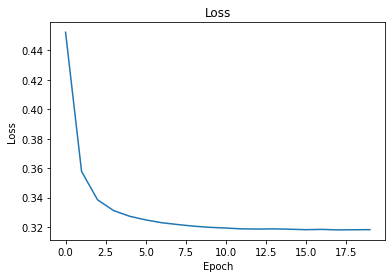

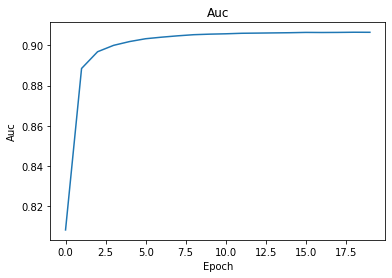

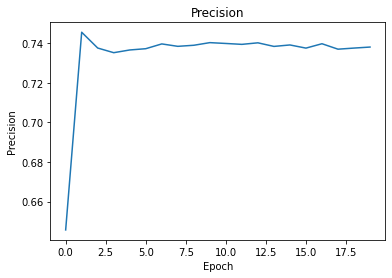

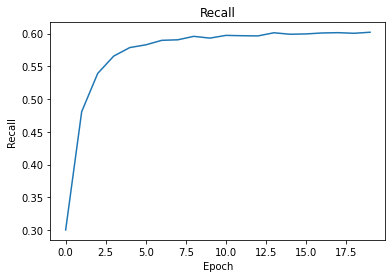

In [99]:
plot_metrics(hist)

In [100]:
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))

predictions = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

163/163 [==============================] - 0s 2ms/step - loss: 0.3183 - accuracy: 0.8539 - precision: 0.7289 - recall: 0.6076 - tp: 2337.0000 - fp: 869.0000 - tn: 11566.0000 - fn: 1509.0000 - auc: 0.9050


In [0]:
#predictions[0]

In [102]:
#build dataframe of confusion matrix
cm = pd.DataFrame({0:[predictions[6],predictions[7]],
      1:[predictions[5],predictions[4]]
})
cm

,0,1
0,11566.0,869.0
1,1509.0,2337.0


In [0]:
#cm[0][0]

In [0]:
def plot_cm(cm):
  plt.figure(figsize=(12,8))
  sns.heatmap(cm, annot=True, fmt='g')
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('(True Negatives): ', cm[0][0])
  print('(False Positives): ', cm[0][1])
  print('(False Negatives): ', cm[1][0])
  print('(True Positives): ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

(True Negatives):  11566.0
(False Positives):  1509.0
(False Negatives):  869.0
(True Positives):  2337.0
Total:  3206.0


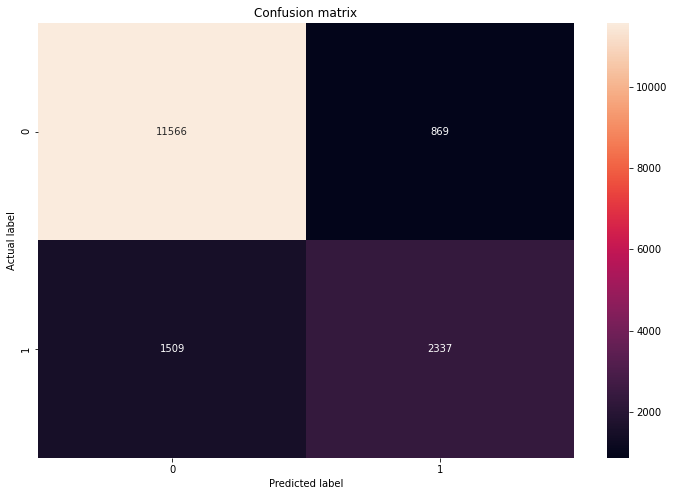

In [105]:
plot_cm(cm)

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [0]:
train_features = {name:np.array(value) for name, value in train_df.items()}
train_label = np.array(train_features.pop(label_name))

val_features = {name:np.array(value) for name, value in val_df.items()}
val_label = np.array(val_features.pop(label_name))

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))

In [0]:
val_predictions = my_model.predict(x = val_features, batch_size=batch_size)
train_predictions = my_model.predict(x = train_features, batch_size=batch_size)
test_predictions = my_model.predict(x = test_features, batch_size=batch_size)

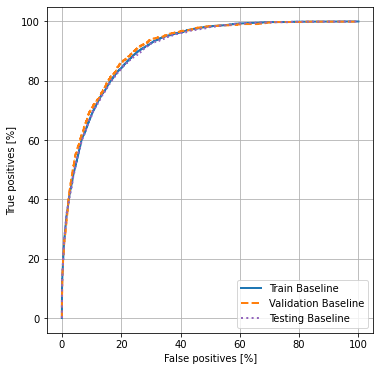

In [109]:
import sklearn
plt.figure(figsize=(12,6))
plot_roc("Train Baseline", train_label, train_predictions, color=colors[0])
plot_roc("Validation Baseline", val_label, val_predictions, color=colors[1], linestyle='--')
plot_roc("Testing Baseline", test_label, test_predictions, color=colors[4], linestyle='dotted')
plt.legend(loc='lower right')


<h4>Train with Cross Validation</h4>

In [110]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_val_model(model, train_dataset,val_dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  train_features = {name:np.array(value) for name, value in train_dataset.items()}
  train_label = np.array(train_features.pop(label_name)) 
  val_features = {name:np.array(value) for name, value in val_dataset.items()}
  val_label = np.array(val_features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle,
                     validation_data = (val_features, val_label))
  
  # The list of epochs is stored separately from the rest of history.
  #epochs = history.epoch

  # Isolate the classification metric for each epoch.
  #hist = pd.DataFrame(history.history)

  return history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [111]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.5
label_name = "Target"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(name='recall',thresholds=classification_threshold,),
      tf.keras.metrics.TruePositives(name='tp',thresholds=classification_threshold),
      tf.keras.metrics.FalsePositives(name='fp',thresholds=classification_threshold),
      tf.keras.metrics.TrueNegatives(name='tn',thresholds=classification_threshold),
      tf.keras.metrics.FalseNegatives(name='fn',thresholds=classification_threshold), 
      tf.keras.metrics.AUC(name='auc')
           
      
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
history = train_val_model(my_model, train_df,val_df, epochs, 
                           label_name, batch_size)



Epoch 1/20
163/163 [==============================] - 1s 9ms/step - loss: 0.4750 - accuracy: 0.7731 - precision: 0.5425 - recall: 0.2525 - tp: 971.0000 - fp: 819.0000 - tn: 11616.0000 - fn: 2875.0000 - auc: 0.7529 - val_loss: 0.4292 - val_accuracy: 0.7947 - val_precision: 0.6932 - val_recall: 0.2986 - val_tp: 479.0000 - val_fp: 212.0000 - val_tn: 4697.0000 - val_fn: 1125.0000 - val_auc: 0.8266
Epoch 2/20
163/163 [==============================] - 1s 3ms/step - loss: 0.3970 - accuracy: 0.8140 - precision: 0.7041 - recall: 0.3664 - tp: 1409.0000 - fp: 592.0000 - tn: 11843.0000 - fn: 2437.0000 - auc: 0.8492 - val_loss: 0.3822 - val_accuracy: 0.8240 - val_precision: 0.7267 - val_recall: 0.4576 - val_tp: 734.0000 - val_fp: 276.0000 - val_tn: 4633.0000 - val_fn: 870.0000 - val_auc: 0.8709
Epoch 3/20
163/163 [==============================] - 1s 3ms/step - loss: 0.3640 - accuracy: 0.8334 - precision: 0.7268 - recall: 0.4724 - tp: 1817.0000 - fp: 683.0000 - tn: 11752.0000 - fn: 2029.0000 - auc

In [0]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.figure()
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[2], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.title(name)
    plt.legend()

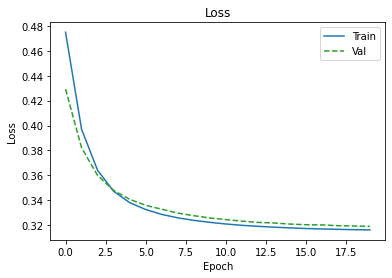

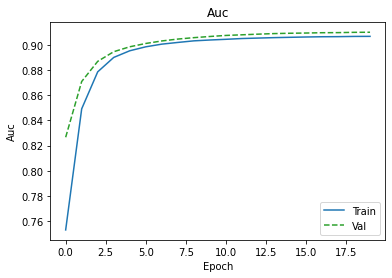

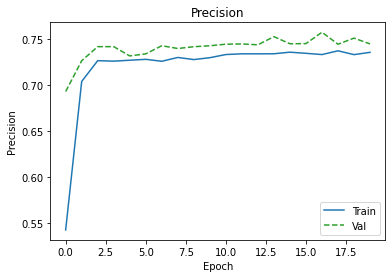

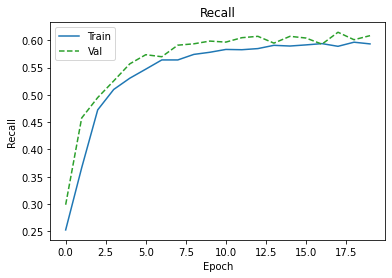

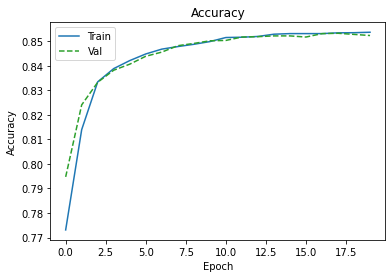

In [113]:
plot_metrics(history)

In [114]:
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))

predictions = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

163/163 [==============================] - 0s 2ms/step - loss: 0.3156 - accuracy: 0.8543 - precision: 0.7377 - recall: 0.5946 - tp: 2287.0000 - fp: 813.0000 - tn: 11622.0000 - fn: 1559.0000 - auc: 0.9072


(True Negatives):  11622.0
(False Positives):  1559.0
(False Negatives):  813.0
(True Positives):  2287.0
Total:  3100.0


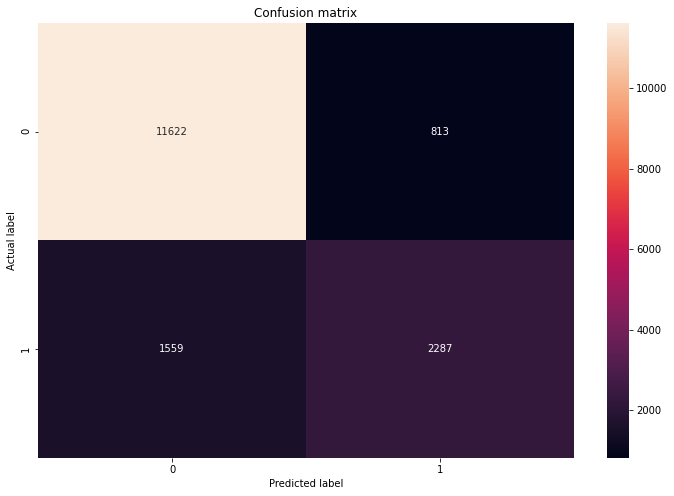

In [115]:
#build dataframe of confusion matrix
cm = pd.DataFrame({0:[predictions[6],predictions[7]],
      1:[predictions[5],predictions[4]]
})

plot_cm(cm)
